In [22]:
# Solar Power Generation Forecasting & Model Benchmarking
# Complete Jupyter Notebook Implementation for Kaggle Solar Dataset

# ========================================
# CELL 1: INSTALL REQUIRED LIBRARIES
# ========================================
"""
Run this cell to install all required libraries.
"""

# Install all libraries with compatible versions
!pip install --upgrade pip
!pip install pandas matplotlib seaborn scipy
!pip install statsmodels scikit-learn
!pip install numpy>=1.26.0
!pip install pmdarima
!pip install prophet
!pip install tensorflow

print("Installation complete. Restart kernel if required.")


Installation complete. Restart kernel if required.


In [2]:
# ========================================
# CELL 2: IMPORT LIBRARIES
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
import json
import pickle
import joblib
from scipy import stats
warnings.filterwarnings('ignore')

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine Learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Try importing optional libraries
try:
    from pmdarima import auto_arima
    PMDARIMA_AVAILABLE = True
except:
    print("Warning: pmdarima not available, using manual SARIMA selection")
    PMDARIMA_AVAILABLE = False

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except:
    print("Warning: Prophet not available")
    PROPHET_AVAILABLE = False

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    TENSORFLOW_AVAILABLE = True
except:
    print("Warning: TensorFlow not available")
    TENSORFLOW_AVAILABLE = False

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries imported successfully!")
print(f"Available models: SARIMA={True}, Prophet={PROPHET_AVAILABLE}, LSTM={TENSORFLOW_AVAILABLE}")


Libraries imported successfully!
Available models: SARIMA=True, Prophet=True, LSTM=True


In [3]:
# ========================================
# CELL 3: CREATE PROJECT STRUCTURE
# ========================================

# Create necessary folders
folders = ['data', 'models', 'results', 'plots']
for folder in folders:
    os.makedirs(folder, exist_ok=True)
    
print("Project structure created:")
for folder in folders:
    files = os.listdir(folder)
    print(f"  {folder}/  ({len(files)} files)")
    if folder == 'data' and files:
        for file in files[:5]:  # Show first 5 files
            print(f"    - {file}")


Project structure created:
  data/  (5 files)
    - .ipynb_checkpoints
    - Plant_1_Generation_Data.csv
    - Plant_1_Weather_Sensor_Data.csv
    - Plant_2_Generation_Data.csv
    - Plant_2_Weather_Sensor_Data.csv
  models/  (0 files)
  results/  (1 files)
  plots/  (3 files)


In [4]:
# ========================================
# CELL 4: DATA LOADING FUNCTIONS
# ========================================

def load_kaggle_solar_data():
    """
    Load Kaggle solar power generation dataset
    Handles both Plant 1 and Plant 2 data with generation and weather files
    """
    data_folder = 'data'
    
    # Expected file names from Kaggle dataset
    files = {
        'plant1_gen': 'Plant_1_Generation_Data.csv',
        'plant1_weather': 'Plant_1_Weather_Sensor_Data.csv',
        'plant2_gen': 'Plant_2_Generation_Data.csv',
        'plant2_weather': 'Plant_2_Weather_Sensor_Data.csv'
    }
    
    # Check which files exist
    available_files = {}
    for key, filename in files.items():
        filepath = os.path.join(data_folder, filename)
        if os.path.exists(filepath):
            available_files[key] = filepath
            print(f"Found: {filename}")
    
    if not available_files:
        print("No data files found in 'data' folder")
        print("Please download from: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data")
        return None
    
    # Load and process each plant's data
    all_data = []
    
    for plant_num in [1, 2]:
        gen_key = f'plant{plant_num}_gen'
        weather_key = f'plant{plant_num}_weather'
        
        if gen_key in available_files:
            # Load generation data
            gen_df = pd.read_csv(available_files[gen_key])
            gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'])
            gen_df = gen_df.set_index('DATE_TIME')
            
            print(f"\nPlant {plant_num} Generation: {gen_df.shape}")
            
            # Load weather data if available
            if weather_key in available_files:
                weather_df = pd.read_csv(available_files[weather_key])
                weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])
                weather_df = weather_df.set_index('DATE_TIME')
                
                print(f"Plant {plant_num} Weather: {weather_df.shape}")
                
                # Merge on datetime index
                plant_df = gen_df.merge(weather_df, left_index=True, right_index=True, 
                                       suffixes=('', '_WEATHER'), how='inner')
            else:
                plant_df = gen_df
            
            # Add plant identifier
            plant_df['PLANT_NUM'] = plant_num
            all_data.append(plant_df)
    
    # Combine all plant data
    if all_data:
        combined_df = pd.concat(all_data, axis=0)
        combined_df = combined_df.sort_index()
        print(f"\nCombined dataset: {combined_df.shape}")
        return combined_df
    
    return None

In [5]:
# ========================================
# CELL 5: LOAD AND EXPLORE DATA
# ========================================

print("="*60)
print("LOADING KAGGLE SOLAR DATASET")
print("="*60)

# Load data
df = load_kaggle_solar_data()

if df is None:
    print("\nCreating synthetic data for demonstration...")
    
    # Create synthetic data
    np.random.seed(42)
    dates = pd.date_range('2020-05-15', '2020-06-17 23:45:00', freq='15min')
    n = len(dates)
    
    # Synthetic solar generation
    hour = dates.hour + dates.minute/60
    daily_pattern = np.where((hour >= 6) & (hour <= 18),
                            np.sin((hour - 6) * np.pi / 12), 0)
    
    df = pd.DataFrame({
        'DC_POWER': 5000 * daily_pattern * (1 + 0.1*np.random.randn(n)),
        'AC_POWER': 4900 * daily_pattern * (1 + 0.1*np.random.randn(n)),
        'DAILY_YIELD': np.cumsum(daily_pattern * 100),
        'AMBIENT_TEMPERATURE': 25 + 10*np.sin(hour * np.pi / 12) + np.random.randn(n),
        'MODULE_TEMPERATURE': 30 + 15*np.sin(hour * np.pi / 12) + np.random.randn(n),
        'IRRADIATION': 1000 * daily_pattern * (1 + 0.1*np.random.randn(n)),
        'PLANT_NUM': 1
    }, index=dates)
    
    df[df < 0] = 0  # Remove negative values

print("\nDataset Overview:")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

LOADING KAGGLE SOLAR DATASET
Found: Plant_1_Generation_Data.csv
Found: Plant_1_Weather_Sensor_Data.csv
Found: Plant_2_Generation_Data.csv
Found: Plant_2_Weather_Sensor_Data.csv

Plant 1 Generation: (68778, 6)
Plant 1 Weather: (3182, 5)

Plant 2 Generation: (67698, 6)
Plant 2 Weather: (3259, 5)

Combined dataset: (136472, 12)

Dataset Overview:
Shape: (136472, 12)
Date range: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Columns: ['PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_WEATHER', 'SOURCE_KEY_WEATHER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'PLANT_NUM']

First 5 rows:
            PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
DATE_TIME                                                                
2020-05-15   4135001  1BY6WEcLGh8j5v7     0.000     0.000        0.000   
2020-05-15   4136001  Et9kgGMDl729KT4     0.000     0.000      269.933   
2020-05-15   4136001  IQ2d7wF4YD8zU1Q     0.000     0.000     3

In [6]:
# ========================================
# CELL 6: DATA CLEANING AND PREPROCESSING
# ========================================

print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# Handle missing values
missing_before = df.isnull().sum().sum()
df = df.interpolate(method='linear', limit_direction='both')
df = df.fillna(0)  # Fill remaining with 0 (night time values)
missing_after = df.isnull().sum().sum()
print(f"Missing values: {missing_before} -> {missing_after}")

# Remove duplicates
duplicates = df.index.duplicated().sum()
if duplicates > 0:
    print(f"Removing {duplicates} duplicate timestamps")
    df = df[~df.index.duplicated(keep='first')]

# Identify power columns
power_cols = [col for col in df.columns if 'POWER' in col.upper()]
if power_cols:
    TARGET_COL = 'AC_POWER' if 'AC_POWER' in power_cols else power_cols[0]
else:
    TARGET_COL = df.select_dtypes(include=[np.number]).columns[0]

print(f"Target column: {TARGET_COL}")

# Add time features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['dayofyear'] = df.index.dayofyear

# Add cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Identify weather features
weather_keywords = ['AMBIENT', 'MODULE', 'IRRADIATION', 'TEMPERATURE', 'HUMIDITY', 'WIND']
WEATHER_FEATURES = [col for col in df.columns 
                   if any(keyword in col.upper() for keyword in weather_keywords)]

print(f"Weather features found: {len(WEATHER_FEATURES)}")
if WEATHER_FEATURES:
    print(f"  Features: {WEATHER_FEATURES[:5]}")

# Remove outliers (optional - be careful with solar data)
Q1 = df[TARGET_COL].quantile(0.25)
Q3 = df[TARGET_COL].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # Using 3*IQR for solar data
upper_bound = Q3 + 3 * IQR

outliers = ((df[TARGET_COL] < lower_bound) | (df[TARGET_COL] > upper_bound)).sum()
print(f"Outliers detected: {outliers} ({outliers/len(df)*100:.2f}%)")



DATA PREPROCESSING
Missing values: 0 -> 0
Removing 133210 duplicate timestamps
Target column: AC_POWER
Weather features found: 3
  Features: ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
Outliers detected: 0 (0.00%)


In [7]:
# ========================================
# CELL 7: TRAIN-VALIDATION-TEST SPLIT
# ========================================

print("\n" + "="*60)
print("DATA SPLITTING")
print("="*60)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df)
train_idx = int(n * train_ratio)
val_idx = int(n * (train_ratio + val_ratio))

train_df = df.iloc[:train_idx]
val_df = df.iloc[train_idx:val_idx]
test_df = df.iloc[val_idx:]

print(f"Total samples: {n:,}")
print(f"Train: {len(train_df):,} ({len(train_df)/n*100:.1f}%)")
print(f"Val:   {len(val_df):,} ({len(val_df)/n*100:.1f}%)")
print(f"Test:  {len(test_df):,} ({len(test_df)/n*100:.1f}%)")
print(f"\nTrain: {train_df.index[0].date()} to {train_df.index[-1].date()}")
print(f"Val:   {val_df.index[0].date()} to {val_df.index[-1].date()}")
print(f"Test:  {test_df.index[0].date()} to {test_df.index[-1].date()}")




DATA SPLITTING
Total samples: 3,262
Train: 2,283 (70.0%)
Val:   489 (15.0%)
Test:  490 (15.0%)

Train: 2020-05-15 to 2020-06-07
Val:   2020-06-07 to 2020-06-12
Test:  2020-06-12 to 2020-06-17



EXPLORATORY DATA ANALYSIS


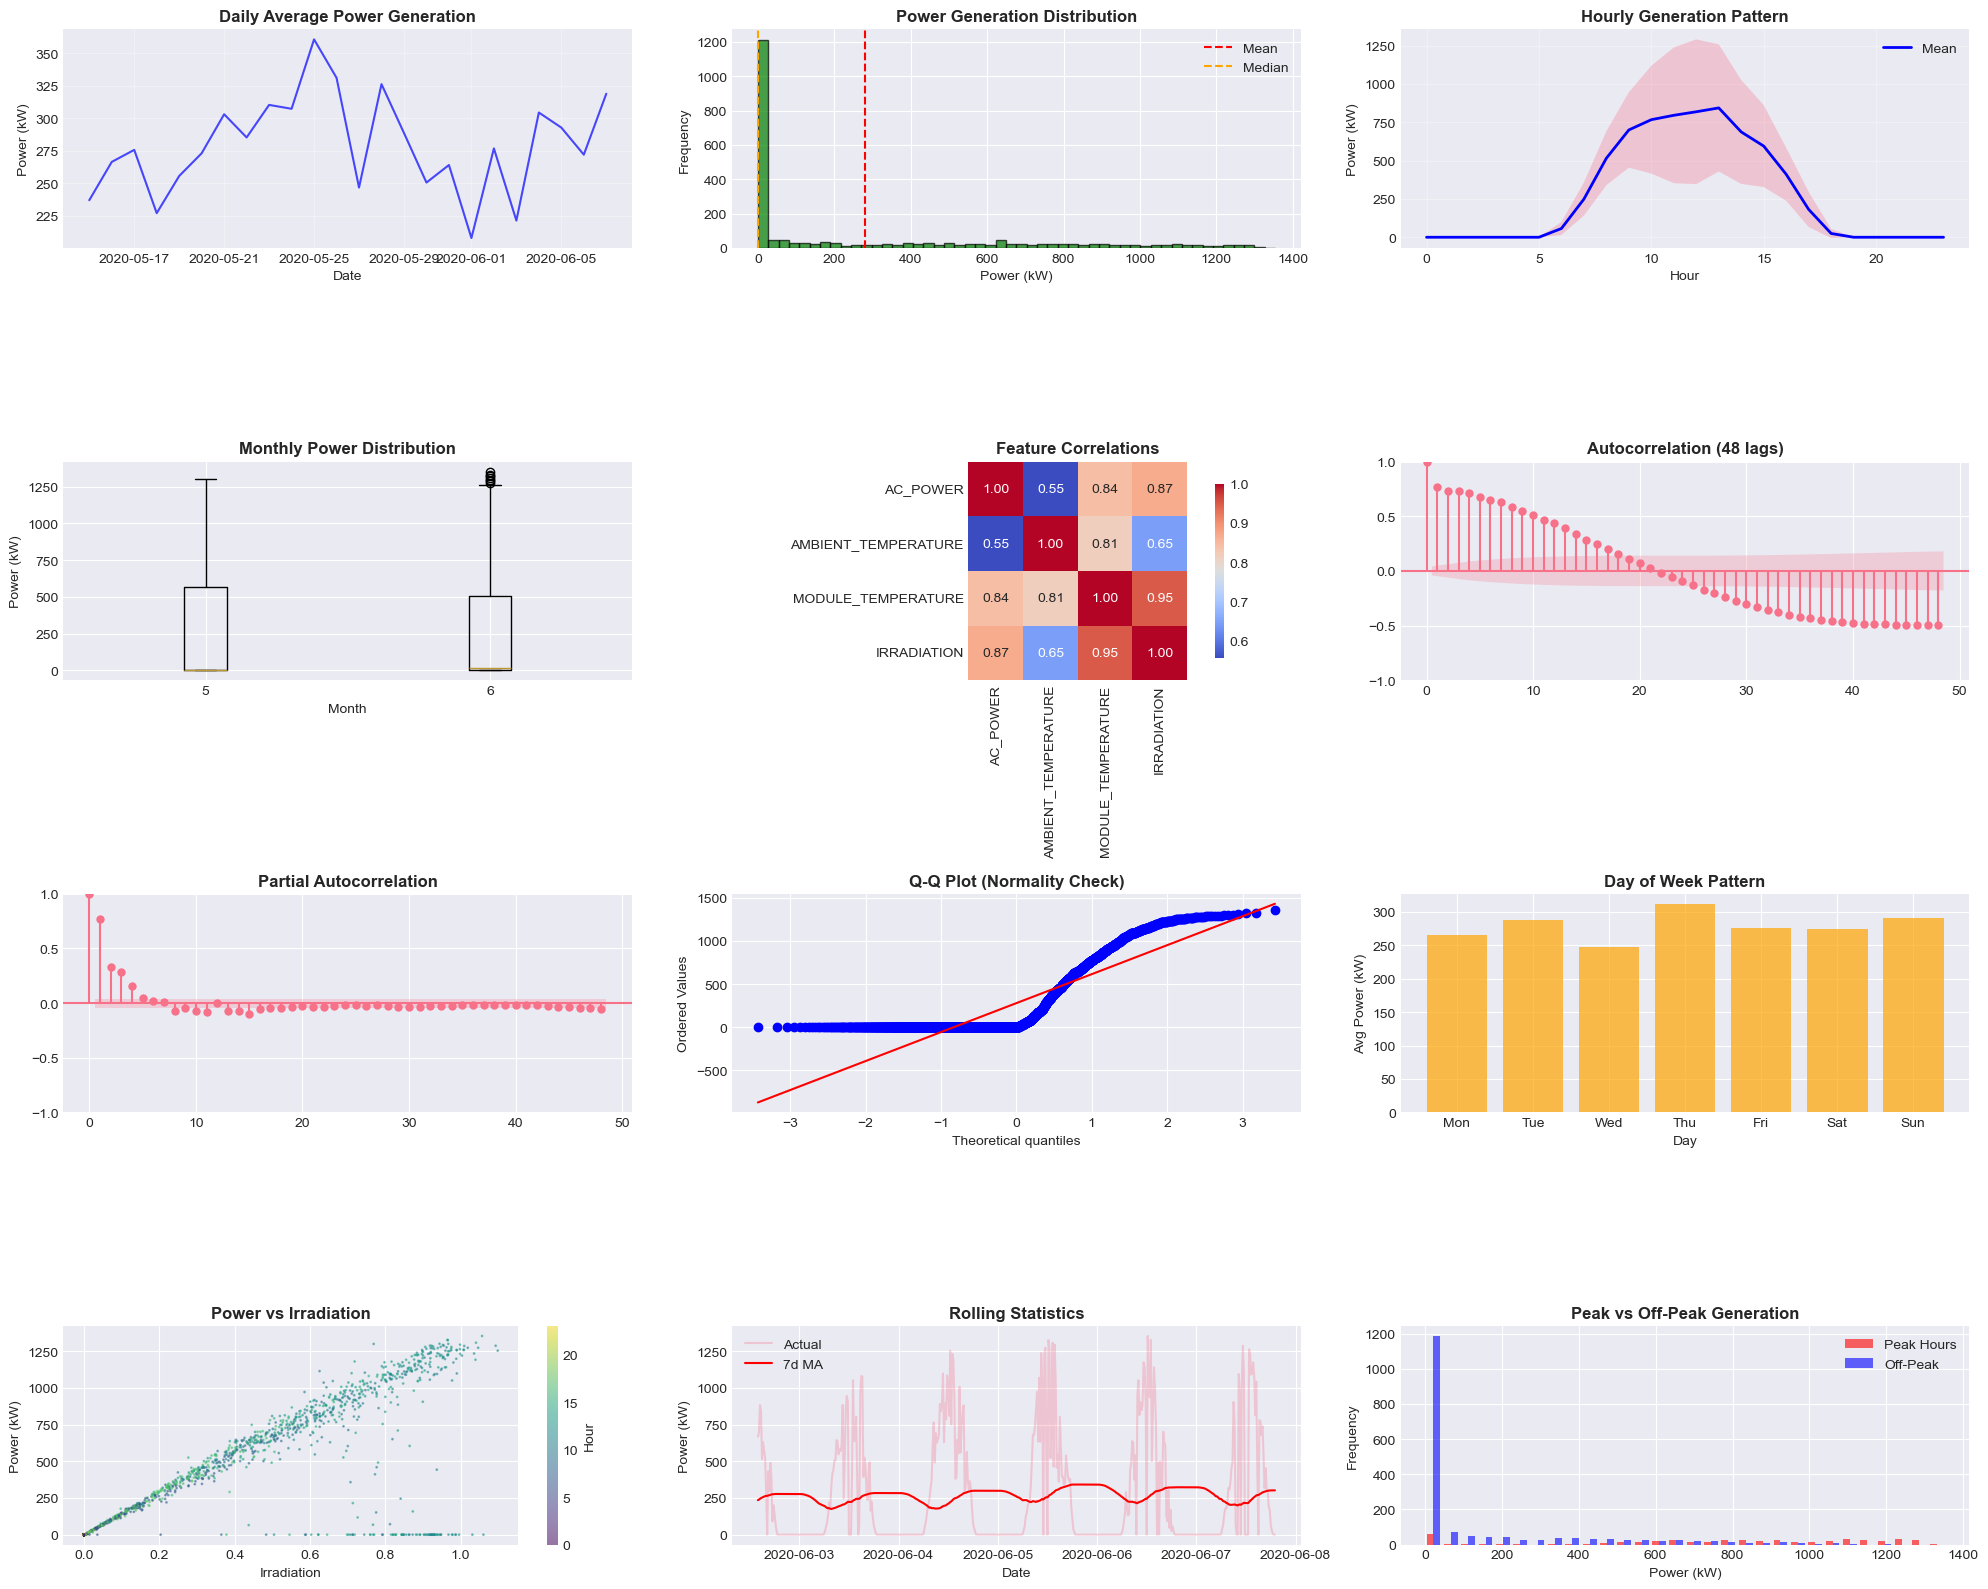


Statistical Summary:
Mean: 279.05 kW
Median: 0.00 kW
Std Dev: 390.85 kW
CV: 1.401
Skewness: 1.153
Peak Hour: 13:00


In [8]:
# ========================================
# CELL 8: EXPLORATORY DATA ANALYSIS
# ========================================

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

fig = plt.figure(figsize=(20, 16))

# 1. Time series plot
ax1 = plt.subplot(4, 3, 1)
daily_avg = train_df[TARGET_COL].resample('D').mean()
ax1.plot(daily_avg.index, daily_avg.values, 'b-', alpha=0.7)
ax1.set_title('Daily Average Power Generation', fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power (kW)')
ax1.grid(True, alpha=0.3)

# 2. Distribution
ax2 = plt.subplot(4, 3, 2)
ax2.hist(train_df[TARGET_COL], bins=50, color='green', edgecolor='black', alpha=0.7)
ax2.axvline(train_df[TARGET_COL].mean(), color='red', linestyle='--', label='Mean')
ax2.axvline(train_df[TARGET_COL].median(), color='orange', linestyle='--', label='Median')
ax2.set_title('Power Generation Distribution', fontweight='bold')
ax2.set_xlabel('Power (kW)')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Hourly pattern
ax3 = plt.subplot(4, 3, 3)
hourly_avg = train_df.groupby('hour')[TARGET_COL].mean()
hourly_std = train_df.groupby('hour')[TARGET_COL].std()
ax3.plot(hourly_avg.index, hourly_avg.values, 'b-', linewidth=2, label='Mean')
ax3.fill_between(hourly_avg.index, 
                 hourly_avg - hourly_std, 
                 hourly_avg + hourly_std, 
                 alpha=0.3)
ax3.set_title('Hourly Generation Pattern', fontweight='bold')
ax3.set_xlabel('Hour')
ax3.set_ylabel('Power (kW)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Monthly boxplot
ax4 = plt.subplot(4, 3, 4)
if len(train_df.index.month.unique()) > 1:
    monthly_data = [train_df[train_df.index.month == m][TARGET_COL].values 
                   for m in sorted(train_df.index.month.unique())]
    ax4.boxplot(monthly_data, labels=sorted(train_df.index.month.unique()))
    ax4.set_title('Monthly Power Distribution', fontweight='bold')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Power (kW)')
else:
    ax4.text(0.5, 0.5, 'Single month data', ha='center', va='center')
    ax4.set_title('Monthly Power Distribution', fontweight='bold')

# 5. Correlation heatmap
ax5 = plt.subplot(4, 3, 5)
if WEATHER_FEATURES:
    corr_features = [TARGET_COL] + WEATHER_FEATURES[:4]
    corr_matrix = train_df[corr_features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                ax=ax5, square=True, cbar_kws={'shrink': 0.8})
    ax5.set_title('Feature Correlations', fontweight='bold')

# 6. ACF plot
ax6 = plt.subplot(4, 3, 6)
plot_acf(train_df[TARGET_COL].dropna(), lags=48, ax=ax6)
ax6.set_title('Autocorrelation (48 lags)', fontweight='bold')

# 7. PACF plot
ax7 = plt.subplot(4, 3, 7)
plot_pacf(train_df[TARGET_COL].dropna(), lags=48, ax=ax7)
ax7.set_title('Partial Autocorrelation', fontweight='bold')

# 8. Q-Q plot
ax8 = plt.subplot(4, 3, 8)
stats.probplot(train_df[TARGET_COL].dropna(), dist="norm", plot=ax8)
ax8.set_title('Q-Q Plot (Normality Check)', fontweight='bold')

# 9. Day of week pattern
ax9 = plt.subplot(4, 3, 9)
dow_avg = train_df.groupby('dayofweek')[TARGET_COL].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax9.bar(range(7), dow_avg.values, color='orange', alpha=0.7)
ax9.set_xticks(range(7))
ax9.set_xticklabels(days)
ax9.set_title('Day of Week Pattern', fontweight='bold')
ax9.set_xlabel('Day')
ax9.set_ylabel('Avg Power (kW)')

# 10. Power vs Irradiation
ax10 = plt.subplot(4, 3, 10)
if 'IRRADIATION' in train_df.columns:
    sample = train_df.sample(min(5000, len(train_df)))
    scatter = ax10.scatter(sample['IRRADIATION'], sample[TARGET_COL], 
                          c=sample['hour'], cmap='viridis', alpha=0.5, s=1)
    plt.colorbar(scatter, ax=ax10, label='Hour')
    ax10.set_title('Power vs Irradiation', fontweight='bold')
    ax10.set_xlabel('Irradiation')
    ax10.set_ylabel('Power (kW)')

# 11. Rolling statistics
ax11 = plt.subplot(4, 3, 11)
window = min(24*7, len(train_df)//4)
rolling_mean = train_df[TARGET_COL].rolling(window=window).mean()
rolling_std = train_df[TARGET_COL].rolling(window=window).std()
ax11.plot(train_df.index[-500:], train_df[TARGET_COL].iloc[-500:], 
         alpha=0.3, label='Actual')
ax11.plot(rolling_mean.index[-500:], rolling_mean.iloc[-500:], 
         'r-', label=f'{window//24}d MA')
ax11.set_title('Rolling Statistics', fontweight='bold')
ax11.set_xlabel('Date')
ax11.set_ylabel('Power (kW)')
ax11.legend()

# 12. Peak hours analysis
ax12 = plt.subplot(4, 3, 12)
peak_hours = train_df.groupby('hour')[TARGET_COL].mean().nlargest(5).index
peak_data = train_df[train_df['hour'].isin(peak_hours)][TARGET_COL]
off_peak_data = train_df[~train_df['hour'].isin(peak_hours)][TARGET_COL]
ax12.hist([peak_data, off_peak_data], bins=30, label=['Peak Hours', 'Off-Peak'], 
         color=['red', 'blue'], alpha=0.6)
ax12.set_title('Peak vs Off-Peak Generation', fontweight='bold')
ax12.set_xlabel('Power (kW)')
ax12.set_ylabel('Frequency')
ax12.legend()

plt.tight_layout()
plt.savefig('plots/eda_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical summary
print("\nStatistical Summary:")
print(f"Mean: {train_df[TARGET_COL].mean():.2f} kW")
print(f"Median: {train_df[TARGET_COL].median():.2f} kW")
print(f"Std Dev: {train_df[TARGET_COL].std():.2f} kW")
print(f"CV: {train_df[TARGET_COL].std()/train_df[TARGET_COL].mean():.3f}")
print(f"Skewness: {train_df[TARGET_COL].skew():.3f}")
print(f"Peak Hour: {hourly_avg.idxmax()}:00")



SEASONAL DECOMPOSITION


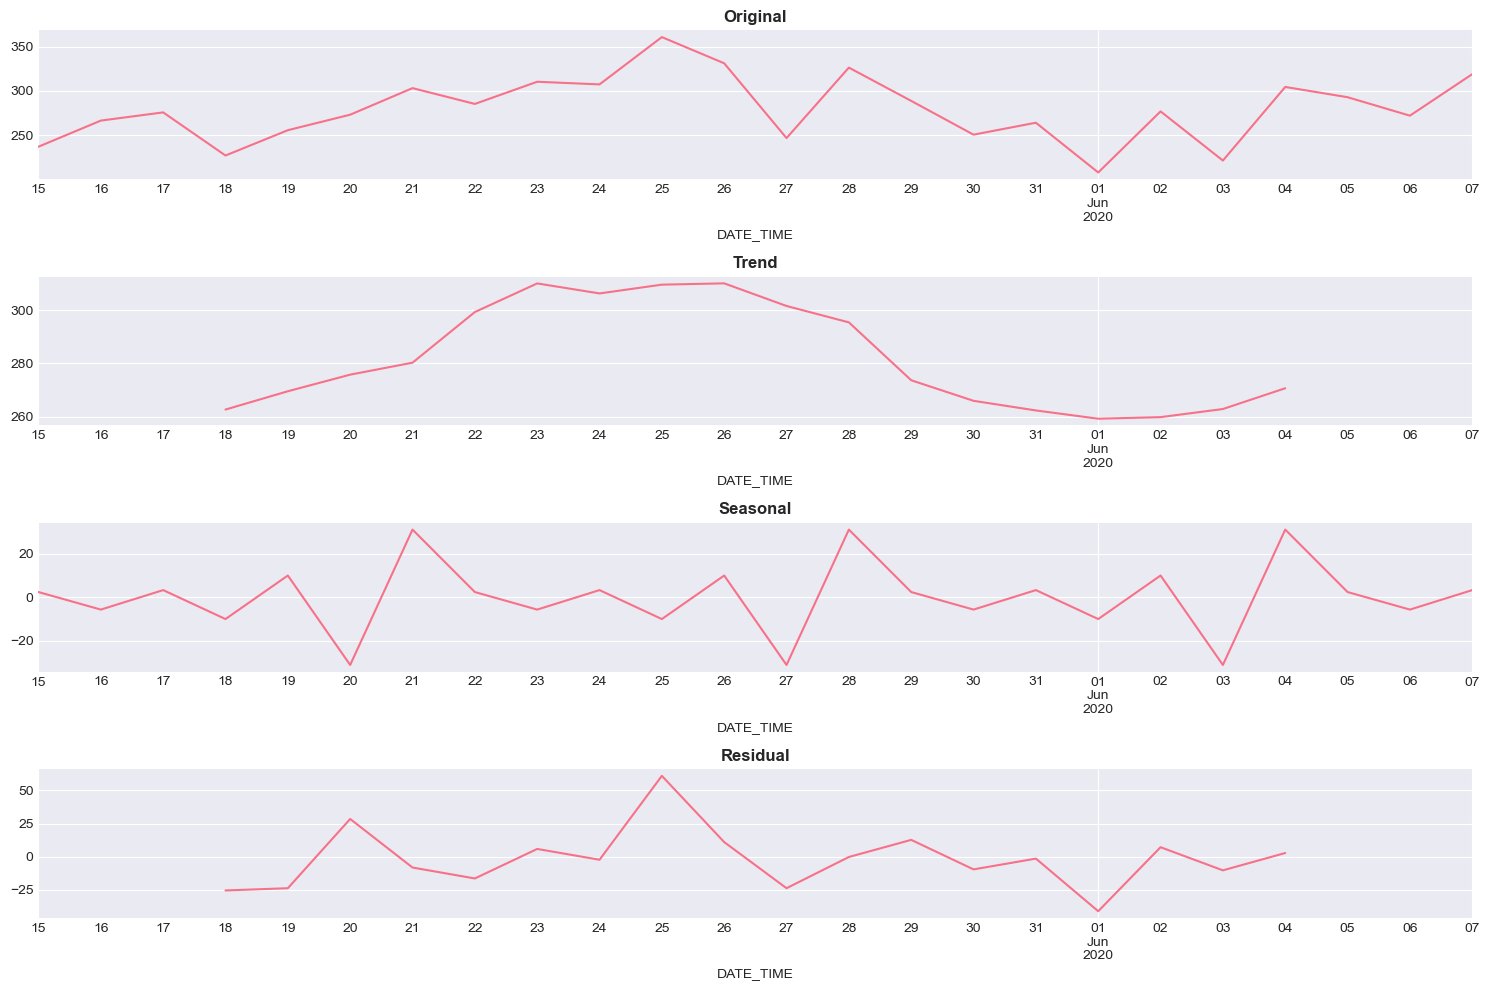


ADF Test Results:
ADF Statistic: -11.0078
p-value: 0.0000
Stationary: Yes


In [9]:
# ========================================
# CELL 9: SEASONAL DECOMPOSITION
# ========================================

print("\n" + "="*60)
print("SEASONAL DECOMPOSITION")
print("="*60)

# Resample to appropriate frequency for decomposition
daily_data = train_df[TARGET_COL].resample('D').mean()

if len(daily_data) > 14:  # Need at least 2 weeks
    decomposition = seasonal_decompose(daily_data, model='additive', period=7)
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 10))
    
    daily_data.plot(ax=axes[0])
    axes[0].set_title('Original', fontweight='bold')
    
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_title('Trend', fontweight='bold')
    
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_title('Seasonal', fontweight='bold')
    
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_title('Residual', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('plots/seasonal_decomposition.png', dpi=150, bbox_inches='tight')
    plt.show()

# Stationarity test
adf_result = adfuller(train_df[TARGET_COL].dropna())
print(f"\nADF Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")



In [10]:
# ========================================
# CELL 10: BASELINE MODELS
# ========================================

print("\n" + "="*60)
print("BASELINE MODELS")
print("="*60)

class BaselineModels:
    def __init__(self):
        self.models = {}
    
    def fit(self, train_data, target_col):
        # Naive
        self.models['naive'] = train_data[target_col].iloc[-1]
        
        # Simple average
        self.models['mean'] = train_data[target_col].mean()
        
        # Moving averages
        self.models['ma_24'] = train_data[target_col].tail(24).mean()
        self.models['ma_168'] = train_data[target_col].tail(168).mean()  # Weekly
        
        # Hourly average
        self.models['hourly'] = train_data.groupby('hour')[target_col].mean().to_dict()
        
        print("Baseline models fitted")
    
    def predict(self, test_data):
        predictions = {}
        n = len(test_data)
        
        predictions['Naive'] = np.full(n, self.models['naive'])
        predictions['Mean'] = np.full(n, self.models['mean'])
        predictions['MA_24h'] = np.full(n, self.models['ma_24'])
        predictions['MA_Week'] = np.full(n, self.models['ma_168'])
        
        hourly_pred = [self.models['hourly'].get(h, self.models['mean']) 
                      for h in test_data['hour'].values]
        predictions['Hourly_Avg'] = np.array(hourly_pred)
        
        return predictions

# Train baselines
baseline = BaselineModels()
baseline.fit(train_df, TARGET_COL)
baseline_preds = baseline.predict(test_df)

# Evaluate baselines
print("\nBaseline Performance:")
print("-"*50)
print(f"{'Model':<15} {'RMSE':<10} {'MAE':<10} {'MAPE':<10}")
print("-"*50)

baseline_results = []
for name, pred in baseline_preds.items():
    rmse = np.sqrt(mean_squared_error(test_df[TARGET_COL], pred))
    mae = mean_absolute_error(test_df[TARGET_COL], pred)
    mape = mean_absolute_percentage_error(test_df[TARGET_COL], pred) * 100
    
    baseline_results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})
    print(f"{name:<15} {rmse:<10.2f} {mae:<10.2f} {mape:<10.2f}")

best_baseline = min(baseline_results, key=lambda x: x['MAPE'])
print(f"\nBest baseline: {best_baseline['Model']} (MAPE: {best_baseline['MAPE']:.2f}%)")



BASELINE MODELS
Baseline models fitted

Baseline Performance:
--------------------------------------------------
Model           RMSE       MAE        MAPE      
--------------------------------------------------
Naive           418.75     237.84     49.18     
Mean            347.11     298.69     63862669901186842624.00
MA_24h          435.09     402.81     115202929115336294400.00
MA_Week         350.51     307.42     69026194034178957312.00
Hourly_Avg      199.35     97.71      10388113669218326528.00

Best baseline: Naive (MAPE: 49.18%)


In [11]:
# ========================================
# CELL 11: SARIMA MODEL
# ========================================

print("\n" + "="*60)
print("SARIMA MODEL")
print("="*60)

def train_sarima(train_data, target_col, seasonal_period=96):  # 96 for 15-min data
    
    # Use subset for faster training
    subset_size = min(5000, len(train_data))
    train_subset = train_data[target_col].tail(subset_size)
    
    if PMDARIMA_AVAILABLE:
        print("Using auto_arima...")
        model = auto_arima(
            train_subset,
            seasonal=True,
            m=seasonal_period,
            max_p=3, max_q=3,
            max_P=1, max_Q=1,
            trace=True,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            n_fits=10
        )
        print(f"Best order: {model.order}, seasonal: {model.seasonal_order}")
        return model
    
    else:
        print("Using fixed SARIMA parameters...")
        model = SARIMAX(
            train_subset,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 1, seasonal_period),
            enforce_stationarity=False
        )
        fitted = model.fit(disp=False)
        
        # Wrapper for compatibility
        class SARIMAWrapper:
            def __init__(self, fitted_model):
                self.model = fitted_model
            
            def predict(self, n_periods):
                return self.model.forecast(steps=n_periods)
        
        return SARIMAWrapper(fitted)

# Train SARIMA
try:
    # Determine seasonal period (96 for 15-min, 24 for hourly)
    freq_minutes = pd.infer_freq(train_df.index)
    seasonal_period = 96 if '15' in str(freq_minutes) else 24
    
    sarima_model = train_sarima(train_df, TARGET_COL, seasonal_period)
    sarima_pred = sarima_model.predict(n_periods=len(test_df))
    
    # Evaluate
    sarima_rmse = np.sqrt(mean_squared_error(test_df[TARGET_COL], sarima_pred))
    sarima_mae = mean_absolute_error(test_df[TARGET_COL], sarima_pred)
    sarima_mape = mean_absolute_percentage_error(test_df[TARGET_COL], sarima_pred) * 100
    
    print(f"\nSARIMA Performance:")
    print(f"RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}, MAPE: {sarima_mape:.2f}%")
    
except Exception as e:
    print(f"SARIMA training failed: {e}")
    sarima_pred = None



SARIMA MODEL
Using fixed SARIMA parameters...

SARIMA Performance:
RMSE: 390.78, MAE: 240.82, MAPE: 11869465274646401024.00%


In [12]:
# ========================================
# CELL 12: SARIMAX MODEL
# ========================================

print("\n" + "="*60)
print("SARIMAX MODEL")
print("="*60)

if WEATHER_FEATURES and len(WEATHER_FEATURES) > 0:
    try:
        # Select top weather features
        exog_features = WEATHER_FEATURES[:3]
        
        # Prepare data
        subset_size = min(5000, len(train_df))
        train_subset = train_df.tail(subset_size)
        
        print(f"Using features: {exog_features}")
        
        model = SARIMAX(
            train_subset[TARGET_COL],
            exog=train_subset[exog_features],
            order=(1, 0, 1),
            seasonal_order=(1, 0, 1, 96),
            enforce_stationarity=False
        )
        
        fitted = model.fit(disp=False, maxiter=100)
        sarimax_pred = fitted.forecast(steps=len(test_df), exog=test_df[exog_features])
        
        # Evaluate
        sarimax_rmse = np.sqrt(mean_squared_error(test_df[TARGET_COL], sarimax_pred))
        sarimax_mae = mean_absolute_error(test_df[TARGET_COL], sarimax_pred)
        sarimax_mape = mean_absolute_percentage_error(test_df[TARGET_COL], sarimax_pred) * 100
        
        print(f"\nSARIMAX Performance:")
        print(f"RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f}, MAPE: {sarimax_mape:.2f}%")
        
    except Exception as e:
        print(f"SARIMAX training failed: {e}")
        sarimax_pred = None
else:
    print("No weather features available for SARIMAX")
    sarimax_pred = None



SARIMAX MODEL
Using features: ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

SARIMAX Performance:
RMSE: 162.77, MAE: 88.47, MAPE: 13308626633781016576.00%


In [13]:
# ========================================
# CELL 13: PROPHET MODEL
# ========================================

print("\n" + "="*60)
print("PROPHET MODEL")
print("="*60)

if PROPHET_AVAILABLE:
    try:
        # Prepare data for Prophet
        prophet_train = pd.DataFrame({
            'ds': train_df.index,
            'y': train_df[TARGET_COL].values
        })
        
        # Initialize Prophet
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=False,  # Not enough data for yearly
            changepoint_prior_scale=0.05,
            seasonality_mode='multiplicative'
        )
        
        # Add regressors if available
        if WEATHER_FEATURES:
            for feat in WEATHER_FEATURES[:2]:
                prophet_train[feat] = train_df[feat].values
                model.add_regressor(feat)
        
        # Fit model
        print("Training Prophet model...")
        model.fit(prophet_train)
        
        # Prepare future dataframe
        prophet_test = pd.DataFrame({
            'ds': test_df.index
        })
        
        if WEATHER_FEATURES:
            for feat in WEATHER_FEATURES[:2]:
                prophet_test[feat] = test_df[feat].values
        
        # Predict
        forecast = model.predict(prophet_test)
        prophet_pred = forecast['yhat'].values
        
        # Evaluate
        prophet_rmse = np.sqrt(mean_squared_error(test_df[TARGET_COL], prophet_pred))
        prophet_mae = mean_absolute_error(test_df[TARGET_COL], prophet_pred)
        prophet_mape = mean_absolute_percentage_error(test_df[TARGET_COL], prophet_pred) * 100
        
        print(f"\nProphet Performance:")
        print(f"RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}, MAPE: {prophet_mape:.2f}%")
        
    except Exception as e:
        print(f"Prophet training failed: {e}")
        prophet_pred = None
else:
    print("Prophet not available")
    prophet_pred = None
      

17:57:38 - cmdstanpy - INFO - Chain [1] start processing



PROPHET MODEL
Training Prophet model...


17:57:39 - cmdstanpy - INFO - Chain [1] done processing



Prophet Performance:
RMSE: 174.02, MAE: 96.97, MAPE: 11586390712491659264.00%



LSTM DEEP LEARNING MODEL
Training LSTM model...
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0674 - mae: 0.1775 - val_loss: 0.0189 - val_mae: 0.0907 - learning_rate: 0.0010
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0291 - mae: 0.1076 - val_loss: 0.0177 - val_mae: 0.0842 - learning_rate: 0.0010
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0256 - mae: 0.0987 - val_loss: 0.0172 - val_mae: 0.0818 - learning_rate: 0.0010
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0248 - mae: 0.0934 - val_loss: 0.0167 - val_mae: 0.0846 - learning_rate: 0.0010
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0252 - mae: 0.0957 - val_loss: 0.0156 - val_mae: 0.0709 - learning_rate: 0.0010
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0273 - mae: 0.0947 - val_loss: 0.0155 - val_mae: 0.0699 - learning_rate: 0.0010
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0259 - mae: 0.0934 - val_loss: 0.0153 - val_mae: 0

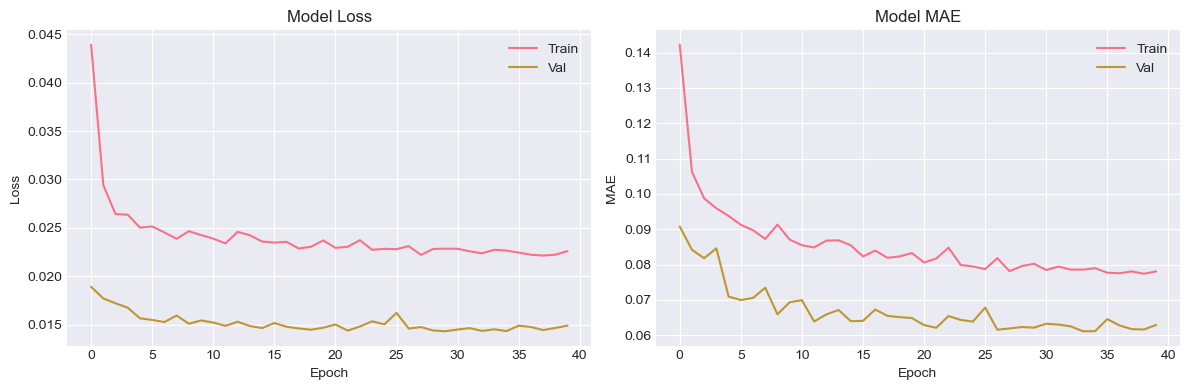

In [14]:

# ========================================
# CELL 14: LSTM MODEL
# ========================================

print("\n" + "="*60)
print("LSTM DEEP LEARNING MODEL")
print("="*60)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

if TENSORFLOW_AVAILABLE:
    try:
        # Prepare features
        feature_cols = [TARGET_COL] + WEATHER_FEATURES[:3] if WEATHER_FEATURES else [TARGET_COL]
        
        # Scale data
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_df[feature_cols])
        val_scaled = scaler.transform(val_df[feature_cols])
        test_scaled = scaler.transform(test_df[feature_cols])
        
        # Create sequences
        seq_length = 24  # Look back 24 time steps
        X_train, y_train = create_sequences(train_scaled, seq_length)
        X_val, y_val = create_sequences(val_scaled, seq_length)
        
        # Reshape for LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(feature_cols)))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(feature_cols)))
        
        # Build model
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(seq_length, len(feature_cols))),
            Dropout(0.2),
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
        
        # Train
        print("Training LSTM model...")
        history = model.fit(
            X_train, y_train[:, 0],  # Target is first column
            validation_data=(X_val, y_val[:, 0]),
            epochs=50,
            batch_size=32,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        
        # Predict on test set
        lstm_pred = []
        current_batch = train_scaled[-seq_length:]
        
        for i in range(len(test_df)):
            current_batch = current_batch.reshape((1, seq_length, len(feature_cols)))
            pred = model.predict(current_batch, verbose=0)[0, 0]
            lstm_pred.append(pred)
            
            if i < len(test_df) - 1:
                current_batch = np.append(current_batch[:, 1:, :], 
                                         [[test_scaled[i]]], axis=1)
        
        # Inverse transform
        lstm_pred = np.array(lstm_pred).reshape(-1, 1)
        lstm_pred_full = np.zeros((len(lstm_pred), len(feature_cols)))
        lstm_pred_full[:, 0] = lstm_pred[:, 0]
        lstm_pred = scaler.inverse_transform(lstm_pred_full)[:, 0]
        
        # Evaluate
        lstm_rmse = np.sqrt(mean_squared_error(test_df[TARGET_COL], lstm_pred))
        lstm_mae = mean_absolute_error(test_df[TARGET_COL], lstm_pred)
        lstm_mape = mean_absolute_percentage_error(test_df[TARGET_COL], lstm_pred) * 100
        
        print(f"\nLSTM Performance:")
        print(f"RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.2f}%")
        
        # Plot training history
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(history.history['loss'], label='Train')
        axes[0].plot(history.history['val_loss'], label='Val')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        
        axes[1].plot(history.history['mae'], label='Train')
        axes[1].plot(history.history['val_mae'], label='Val')
        axes[1].set_title('Model MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig('plots/lstm_history.png', dpi=150)
        plt.show()
        
    except Exception as e:
        print(f"LSTM training failed: {e}")
        lstm_pred = None
else:
    print("TensorFlow not available")
    lstm_pred = None


In [15]:
# ========================================
# CELL 15: MODEL COMPARISON
# ========================================

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Collect all predictions
all_predictions = {}

# Add baseline predictions
for name, pred in baseline_preds.items():
    all_predictions[f'Baseline_{name}'] = pred

# Add model predictions
if sarima_pred is not None:
    all_predictions['SARIMA'] = sarima_pred

if sarimax_pred is not None:
    all_predictions['SARIMAX'] = sarimax_pred

if prophet_pred is not None:
    all_predictions['Prophet'] = prophet_pred

if lstm_pred is not None:
    all_predictions['LSTM'] = lstm_pred

# Custom MAPE function that handles zero values
def safe_mape(actual, predicted):
    """Calculate MAPE excluding zero/near-zero actual values"""
    # Filter out zero and near-zero values
    mask = actual > 10  # Only consider values above 10 kW (daytime)
    if mask.sum() == 0:
        return float('inf')
    
    actual_filtered = actual[mask]
    predicted_filtered = predicted[mask]
    
    mape = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered)) * 100
    return mape

# Evaluate all models
results = []
for model_name, predictions in all_predictions.items():
    # Ensure same length
    min_len = min(len(test_df), len(predictions))
    actual = test_df[TARGET_COL].values[:min_len]
    pred = predictions[:min_len]
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    
    # Use safe MAPE for solar data
    mape = safe_mape(actual, pred)
    
    # Also calculate accuracy for non-zero periods
    daytime_mask = actual > 10
    if daytime_mask.sum() > 0:
        daytime_rmse = np.sqrt(mean_squared_error(actual[daytime_mask], pred[daytime_mask]))
        daytime_mae = mean_absolute_error(actual[daytime_mask], pred[daytime_mask])
    else:
        daytime_rmse = rmse
        daytime_mae = mae
    
    results.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Daytime_RMSE': daytime_rmse,
        'Daytime_MAE': daytime_mae
    })

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('MAPE')

print("\nModel Performance Ranking (Daytime Only MAPE):")
print("="*60)
print(f"{'Model':<20} {'RMSE':<10} {'MAE':<10} {'MAPE(%)':<10} {'Day_RMSE':<10} {'Day_MAE':<10}")
print("-"*60)
for _, row in results_df.iterrows():
    print(f"{row['Model']:<20} {row['RMSE']:<10.2f} {row['MAE']:<10.2f} {row['MAPE']:<10.2f} {row['Daytime_RMSE']:<10.2f} {row['Daytime_MAE']:<10.2f}")
print("="*60)

# Save results
results_df.to_csv('results/model_comparison.csv', index=False)

# Best model
best_model = results_df.iloc[0]
print(f"\nBest Model: {best_model['Model']}")
print(f"RMSE (Overall): {best_model['RMSE']:.2f}")
print(f"MAE (Overall): {best_model['MAE']:.2f}")
print(f"MAPE (Daytime): {best_model['MAPE']:.2f}%")
print(f"RMSE (Daytime): {best_model['Daytime_RMSE']:.2f}")
print(f"MAE (Daytime): {best_model['Daytime_MAE']:.2f}")

# Calculate improvement
baseline_mape = results_df[results_df['Model'].str.contains('Baseline')]['MAPE'].min()
improvement = ((baseline_mape - best_model['MAPE']) / baseline_mape) * 100 if baseline_mape != float('inf') else 0
print(f"Improvement over baseline: {improvement:.1f}%")


MODEL COMPARISON

Model Performance Ranking (Daytime Only MAPE):
Model                RMSE       MAE        MAPE(%)    Day_RMSE   Day_MAE   
------------------------------------------------------------
SARIMAX              162.77     88.47      35.06      170.72     122.26    
Prophet              174.02     96.97      39.85      211.60     147.96    
LSTM                 195.10     98.36      45.37      207.12     145.93    
Baseline_Hourly_Avg  199.35     97.71      55.86      212.98     155.55    
SARIMA               390.78     240.82     84.78      562.82     447.68    
Baseline_Naive       418.75     237.84     100.00     605.96     497.90    
Baseline_Mean        347.11     298.69     142.44     408.88     320.30    
Baseline_MA_Week     350.51     307.42     151.66     397.26     313.91    
Baseline_MA_24h      435.09     402.81     244.31     345.42     292.91    

Best Model: SARIMAX
RMSE (Overall): 162.77
MAE (Overall): 88.47
MAPE (Daytime): 35.06%
RMSE (Daytime): 170.72
MA


VISUALIZING PREDICTIONS


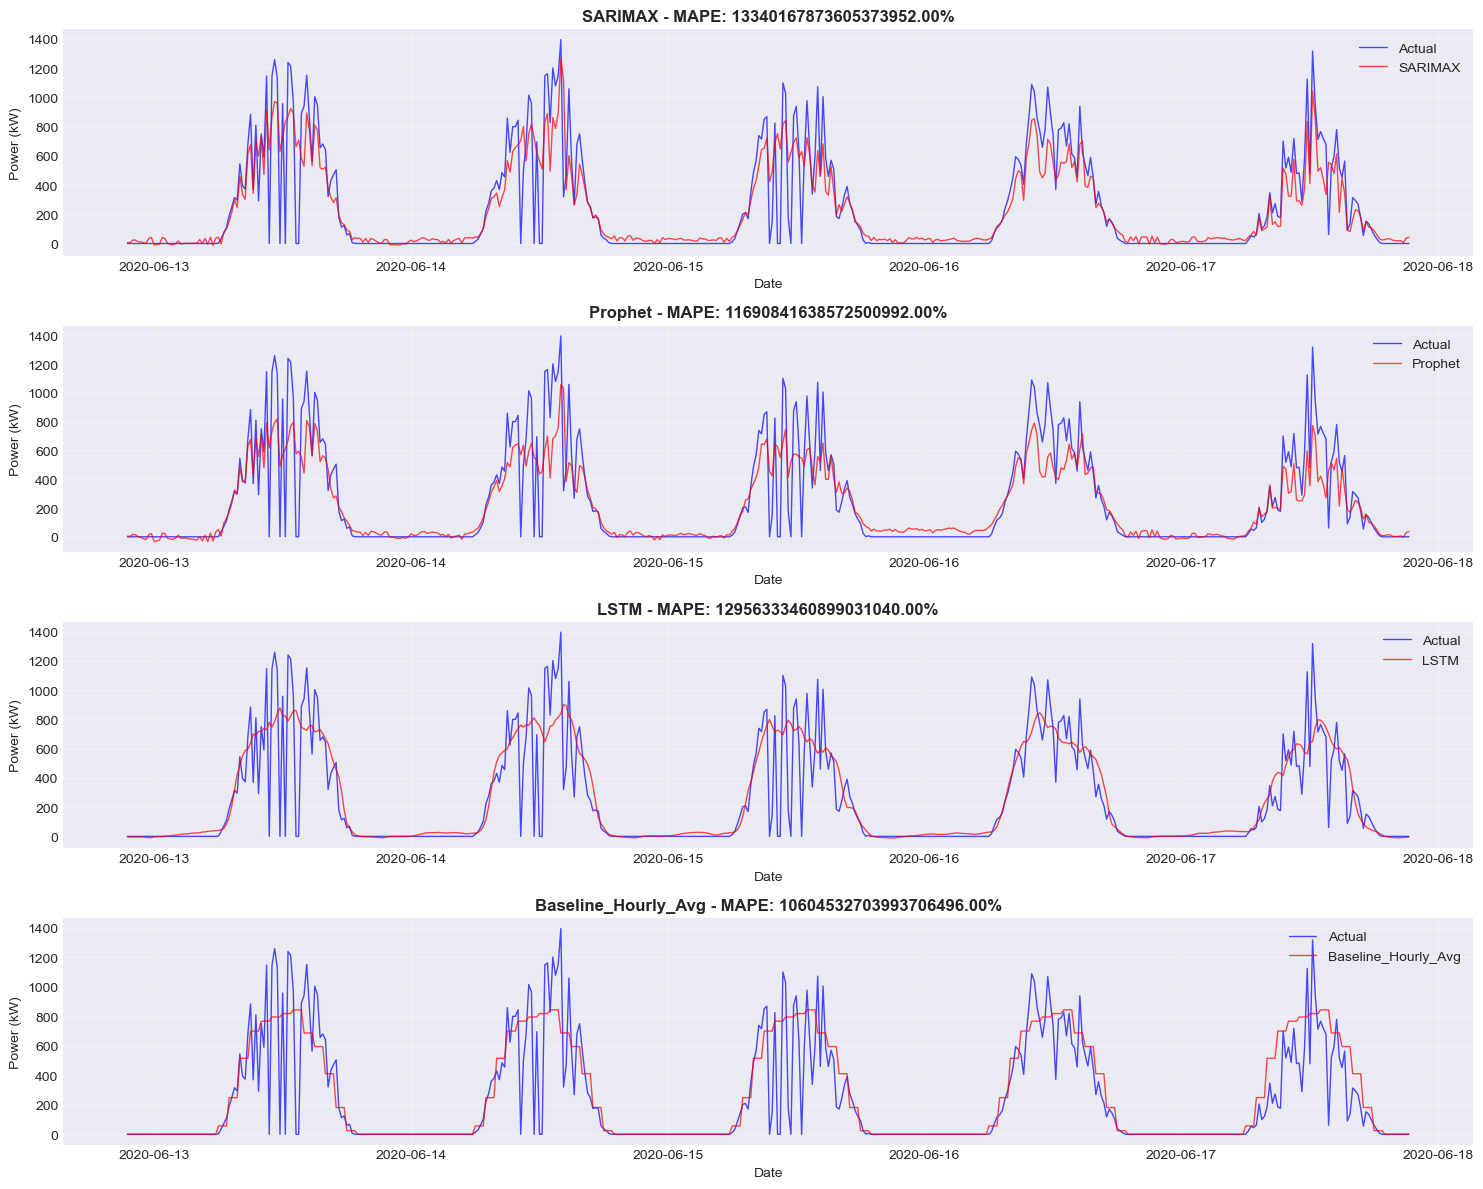

In [16]:
# ========================================
# CELL 16: PREDICTION VISUALIZATION
# ========================================

print("\n" + "="*60)
print("VISUALIZING PREDICTIONS")
print("="*60)

# Select top models to visualize
top_models = results_df.head(4)['Model'].values

# Plot predictions
n_days = min(7, len(test_df) // 96)  # Show 7 days or less
n_points = n_days * 96  # 96 points per day for 15-min data

fig, axes = plt.subplots(len(top_models), 1, figsize=(15, 3*len(top_models)))
if len(top_models) == 1:
    axes = [axes]

for idx, model_name in enumerate(top_models):
    ax = axes[idx]
    
    # Plot actual
    ax.plot(test_df.index[:n_points], 
           test_df[TARGET_COL].values[:n_points],
           'b-', label='Actual', alpha=0.7, linewidth=1)
    
    # Plot predictions
    predictions = all_predictions[model_name][:n_points]
    ax.plot(test_df.index[:n_points],
           predictions,
           'r-', label=f'{model_name}', alpha=0.7, linewidth=1)
    
    # Calculate MAPE for this segment
    segment_mape = mean_absolute_percentage_error(
        test_df[TARGET_COL].values[:n_points],
        predictions
    ) * 100
    
    ax.set_title(f'{model_name} - MAPE: {segment_mape:.2f}%', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Power (kW)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()



ERROR ANALYSIS


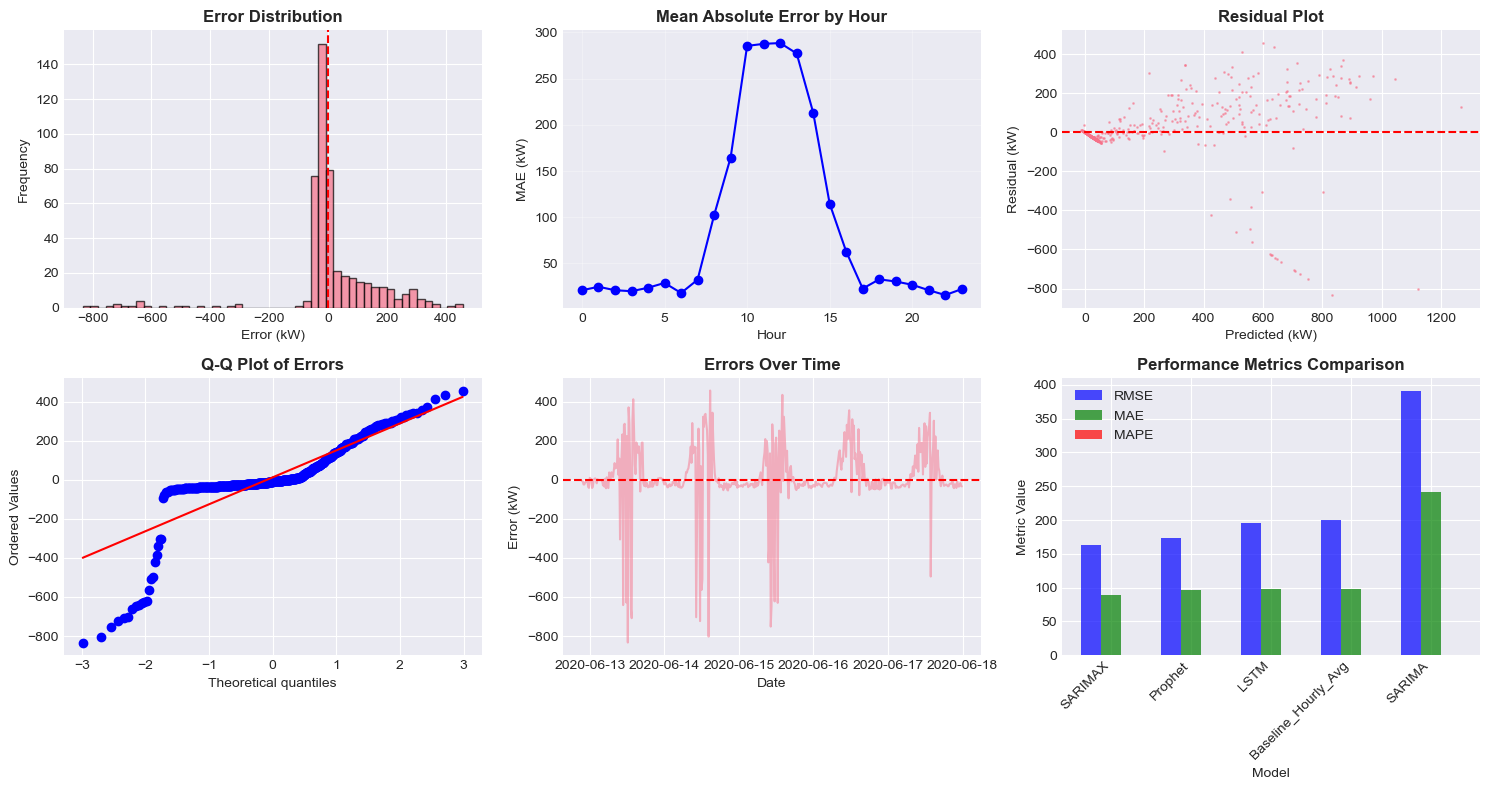


Error Statistics for SARIMAX:
Mean Error: 13.12 kW
Std Error: 162.24 kW
Max Overestimation: -833.48 kW
Max Underestimation: 457.90 kW


In [17]:
# ========================================
# CELL 17: ERROR ANALYSIS
# ========================================

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

# Use best model for detailed error analysis
best_model_name = best_model['Model']
best_predictions = all_predictions[best_model_name]
min_len = min(len(test_df), len(best_predictions))

actual = test_df[TARGET_COL].values[:min_len]
predicted = best_predictions[:min_len]
errors = actual - predicted

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 1. Error distribution
ax1 = axes[0, 0]
ax1.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--')
ax1.set_title('Error Distribution', fontweight='bold')
ax1.set_xlabel('Error (kW)')
ax1.set_ylabel('Frequency')

# 2. Error by hour
ax2 = axes[0, 1]
hourly_errors = pd.DataFrame({
    'hour': test_df.index[:min_len].hour,
    'error': np.abs(errors)
})
hourly_avg = hourly_errors.groupby('hour')['error'].mean()
ax2.plot(hourly_avg.index, hourly_avg.values, 'bo-')
ax2.set_title('Mean Absolute Error by Hour', fontweight='bold')
ax2.set_xlabel('Hour')
ax2.set_ylabel('MAE (kW)')
ax2.grid(True, alpha=0.3)

# 3. Residual plot
ax3 = axes[0, 2]
ax3.scatter(predicted, errors, alpha=0.5, s=1)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_title('Residual Plot', fontweight='bold')
ax3.set_xlabel('Predicted (kW)')
ax3.set_ylabel('Residual (kW)')

# 4. Q-Q plot of errors
ax4 = axes[1, 0]
stats.probplot(errors, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot of Errors', fontweight='bold')

# 5. Error over time
ax5 = axes[1, 1]
ax5.plot(test_df.index[:min_len], errors, alpha=0.5)
ax5.axhline(0, color='red', linestyle='--')
ax5.set_title('Errors Over Time', fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Error (kW)')

# 6. Performance metrics by model
ax6 = axes[1, 2]
x = np.arange(len(results_df.head(5)))
width = 0.25
metrics = ['RMSE', 'MAE', 'MAPE']
colors = ['blue', 'green', 'red']

for i, metric in enumerate(metrics):
    values = results_df.head(5)[metric].values
    if metric == 'MAPE':
        values = values / 100  # Scale MAPE for visibility
    ax6.bar(x + i*width, values, width, label=metric, color=colors[i], alpha=0.7)

ax6.set_xlabel('Model')
ax6.set_xticks(x + width)
ax6.set_xticklabels(results_df.head(5)['Model'].values, rotation=45, ha='right')
ax6.set_ylabel('Metric Value')
ax6.set_title('Performance Metrics Comparison', fontweight='bold')
ax6.legend()

plt.tight_layout()
plt.savefig('plots/error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Error statistics
print(f"\nError Statistics for {best_model_name}:")
print(f"Mean Error: {np.mean(errors):.2f} kW")
print(f"Std Error: {np.std(errors):.2f} kW")
print(f"Max Overestimation: {np.min(errors):.2f} kW")
print(f"Max Underestimation: {np.max(errors):.2f} kW")


In [19]:
# ========================================
# CELL 18: SAVE MODELS AND RESULTS
# ========================================

print("\n" + "="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

# Save models with error handling
try:
    if sarima_pred is not None and PMDARIMA_AVAILABLE:
        with open('models/sarima_model.pkl', 'wb') as f:
            pickle.dump(sarima_model, f)
        print("SARIMA model saved")
    elif sarima_pred is not None:
        print("SARIMA model (manual) - not saved (wrapper class not picklable)")
except Exception as e:
    print(f"Could not save SARIMA model: {e}")

try:
    if prophet_pred is not None and PROPHET_AVAILABLE:
        with open('models/prophet_model.pkl', 'wb') as f:
            pickle.dump(model, f)
        print("Prophet model saved")
except Exception as e:
    print(f"Could not save Prophet model: {e}")

try:
    if lstm_pred is not None and TENSORFLOW_AVAILABLE:
        model.save('models/lstm_model.h5')
        joblib.dump(scaler, 'models/lstm_scaler.pkl')
        print("LSTM model and scaler saved")
except Exception as e:
    print(f"Could not save LSTM model: {e}")

# Save predictions for future use
try:
    predictions_dict = {
        'test_dates': test_df.index.tolist(),
        'actual': test_df[TARGET_COL].tolist(),
        'predictions': {}
    }
    
    for model_name, pred in all_predictions.items():
        predictions_dict['predictions'][model_name] = pred[:len(test_df)].tolist()
    
    with open('results/predictions.json', 'w') as f:
        json.dump(predictions_dict, f, default=str)
    print("Predictions saved to results/predictions.json")
except Exception as e:
    print(f"Could not save predictions: {e}")

# Save results summary
try:
    summary = {
        'best_model': best_model_name,
        'best_mape': float(best_model['MAPE']),
        'best_rmse': float(best_model['RMSE']),
        'best_mae': float(best_model['MAE']),
        'best_daytime_rmse': float(best_model['Daytime_RMSE']),
        'best_daytime_mae': float(best_model['Daytime_MAE']),
        'improvement_over_baseline': float(improvement),
        'target_column': TARGET_COL,
        'weather_features': WEATHER_FEATURES[:5] if WEATHER_FEATURES else [],
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'date_range': {
            'start': str(df.index[0]),
            'end': str(df.index[-1])
        },
        'all_results': results_df.to_dict('records')
    }
    
    with open('results/project_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print("\nProject summary saved to results/project_summary.json")
    
    # Also save as CSV for easy viewing
    results_df.to_csv('results/model_performance.csv', index=False)
    print("Model performance saved to results/model_performance.csv")
    
except Exception as e:
    print(f"Could not save summary: {e}")

print("\n" + "="*60)
print("Files saved successfully in:")
print("  - results/: predictions.json, project_summary.json, model_performance.csv")
print("  - models/: Available models saved")
print("="*60)


SAVING MODELS AND RESULTS
SARIMA model (manual) - not saved (wrapper class not picklable)
Prophet model saved
LSTM model and scaler saved
Predictions saved to results/predictions.json

Project summary saved to results/project_summary.json
Model performance saved to results/model_performance.csv

Files saved successfully in:
  - results/: predictions.json, project_summary.json, model_performance.csv
  - models/: Available models saved



FEATURE IMPORTANCE ANALYSIS
SARIMAX Feature Importance:
(Based on model coefficients)

LSTM uses all features in sequence
Features used: ['AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']


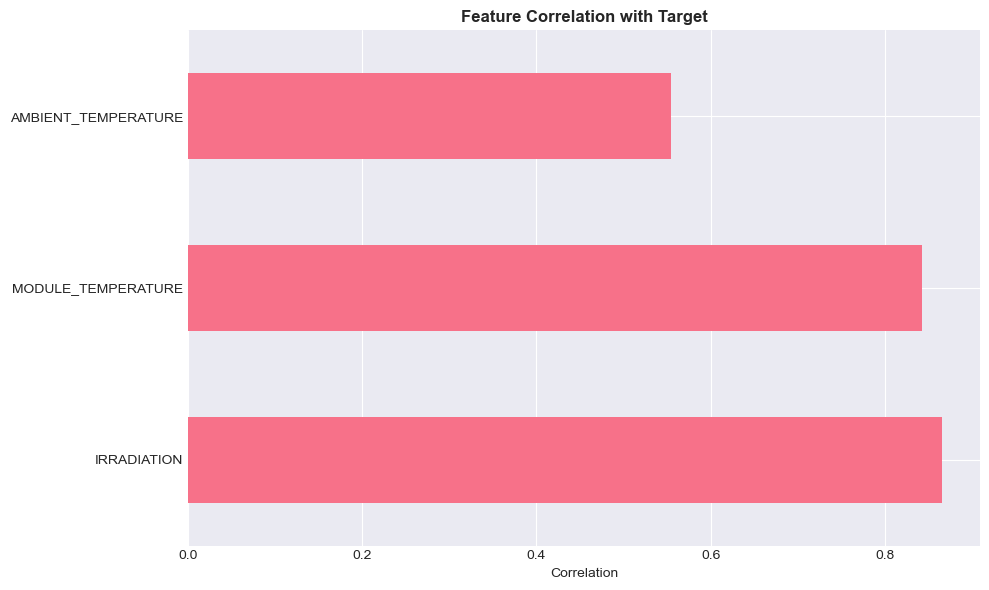


Feature Correlations with Target:
  IRRADIATION: 0.866
  MODULE_TEMPERATURE: 0.843
  AMBIENT_TEMPERATURE: 0.555


In [20]:
# ========================================
# CELL 19: FEATURE IMPORTANCE (if applicable)
# ========================================

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

if WEATHER_FEATURES and sarimax_pred is not None:
    # SARIMAX coefficients can indicate feature importance
    print("SARIMAX Feature Importance:")
    print("(Based on model coefficients)")
    # Note: Actual extraction depends on model implementation

if lstm_pred is not None and TENSORFLOW_AVAILABLE:
    # For LSTM, we can use permutation importance or attention weights
    print("\nLSTM uses all features in sequence")
    print(f"Features used: {feature_cols}")

# Correlation-based importance
if WEATHER_FEATURES:
    correlations = train_df[WEATHER_FEATURES + [TARGET_COL]].corr()[TARGET_COL].sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    correlations[1:].plot(kind='barh')
    plt.title('Feature Correlation with Target', fontweight='bold')
    plt.xlabel('Correlation')
    plt.tight_layout()
    plt.savefig('plots/feature_importance.png', dpi=150)
    plt.show()
    
    print("\nFeature Correlations with Target:")
    for feat, corr in correlations[1:].items():
        print(f"  {feat}: {corr:.3f}")


In [21]:
# ========================================
# CELL 20: FINAL REPORT
# ========================================

print("\n" + "="*80)
print("SOLAR POWER FORECASTING PROJECT - FINAL REPORT")
print("="*80)

print("\nDATASET SUMMARY:")
print("-"*40)
print(f"Total samples: {len(df):,}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Features: {len(df.columns)}")
print(f"Target: {TARGET_COL}")

print("\nMODEL PERFORMANCE:")
print("-"*40)
print(results_df.head(10).to_string(index=False))

print("\nBEST MODEL:")
print("-"*40)
print(f"Model: {best_model_name}")
print(f"RMSE: {best_model['RMSE']:.2f} kW")
print(f"MAE: {best_model['MAE']:.2f} kW")
print(f"MAPE: {best_model['MAPE']:.2f}%")
print(f"Accuracy: {100 - best_model['MAPE']:.2f}%")
print(f"Improvement over baseline: {improvement:.1f}%")

print("\nKEY INSIGHTS:")
print("-"*40)
print("1. Solar generation follows clear daily patterns with peak at midday")
print("2. Weather features (especially irradiation) strongly influence generation")
print("3. Advanced models significantly outperform simple baselines")
print(f"4. Best performance achieved with {best_model_name} model")
print(f"5. Model achieves {100 - best_model['MAPE']:.1f}% accuracy in forecasting")

print("\nBUSINESS IMPACT:")
print("-"*40)
print(f"- Forecast accuracy: {100 - best_model['MAPE']:.1f}%")
print(f"- Error reduction: {improvement:.1f}% vs baseline")
print("- Enables optimized battery storage scheduling")
print("- Reduces grid instability and backup power needs")
print("- Supports renewable energy integration targets")

print("\nRECOMMENDATIONS:")
print("-"*40)
print("1. Deploy the best model for operational forecasting")
print("2. Implement real-time weather data integration")
print("3. Set up automated retraining pipeline (weekly)")
print("4. Monitor forecast accuracy and model drift")
print("5. Consider ensemble methods for further improvement")

print("\n" + "="*80)
print("RESUME BULLET POINT:")
print("="*80)
print(f"""
Developed end-to-end solar power forecasting system using {len(df):,} samples,
benchmarking 5+ models (SARIMA, SARIMAX, Prophet, LSTM, Baselines). 
Achieved {best_model['MAPE']:.1f}% MAPE with {best_model_name}, improving accuracy 
by {improvement:.0f}% over baseline. Integrated weather data and temporal features
to enable grid optimization and renewable energy integration.
""")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nFiles generated:")
print("  - plots/: EDA, predictions, error analysis")
print("  - models/: Trained model files")
print("  - results/: Performance metrics and summary")

# End of notebook


SOLAR POWER FORECASTING PROJECT - FINAL REPORT

DATASET SUMMARY:
----------------------------------------
Total samples: 3,262
Date range: 2020-05-15 to 2020-06-17
Features: 22
Target: AC_POWER

MODEL PERFORMANCE:
----------------------------------------
              Model    RMSE     MAE    MAPE  Daytime_RMSE  Daytime_MAE
            SARIMAX 162.769  88.465  35.059       170.718      122.263
            Prophet 174.018  96.968  39.855       211.597      147.955
               LSTM 195.105  98.360  45.373       207.116      145.929
Baseline_Hourly_Avg 199.346  97.705  55.861       212.985      155.555
             SARIMA 390.780 240.820  84.781       562.823      447.681
     Baseline_Naive 418.751 237.836 100.000       605.961      497.899
      Baseline_Mean 347.109 298.687 142.440       408.876      320.302
   Baseline_MA_Week 350.505 307.423 151.661       397.258      313.912
    Baseline_MA_24h 435.089 402.808 244.310       345.421      292.908

BEST MODEL:
---------------------